Learn the corrected Jacobi iterator (H) for single-phase problems 
* The iterator is shared by different grids 
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the linear

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from functools import reduce

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [12]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

In [6]:
n = 2**5
grid = SingleGrid(size=2,n=n)

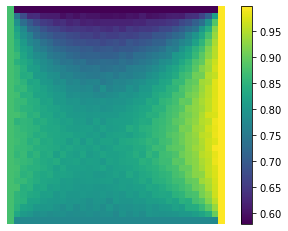

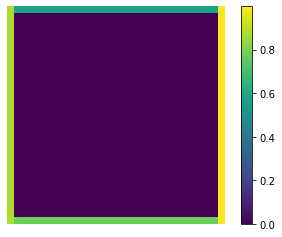

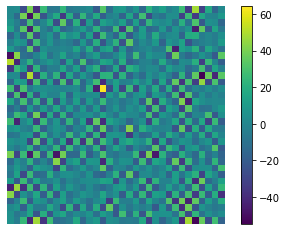

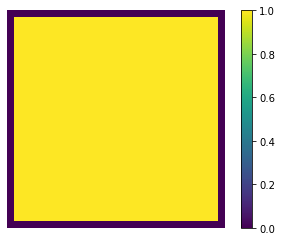

In [7]:
model_name = 'iso_poisson_33x33'

training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_33x33.h5')
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 5.199526786804199
1 3.763766050338745
2 3.0052032470703125
3 2.5279252529144287
4 2.1965510845184326
5 1.95137619972229
6 1.761712670326233
7 1.6100679636001587
8 1.485695719718933
9 1.381605863571167
10 1.2930437326431274
11 1.2166553735733032
12 1.1500027179718018
13 1.091268539428711
14 1.0390688180923462
15 0.992329478263855
16 0.9502037167549133
17 0.9120143055915833
18 0.8772127032279968
19 0.8453493714332581
20 0.8160526156425476
21 0.7890118956565857
22 0.7639658451080322
23 0.7406926155090332
24 0.7190027236938477
25 0.698733389377594
26 0.6797436475753784
27 0.6619110107421875
28 0.6451285481452942
29 0.6293022632598877
30 0.6143493056297302
31 0.6001964807510376
32 0.5867785215377808
33 0.5740373730659485
34 0.5619210004806519
35 0.5503828525543213
36 0.5393809676170349
37 0.528877317905426
38 0.5188378691673279
39 0.5092313885688782
40 0.5000296235084534
41 0.4912068843841553
42 0.48273950815200806
43 0.4746061861515045
44 0.46678704023361206
45 0.45926395058631897
46 0.4

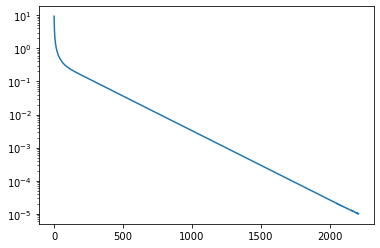

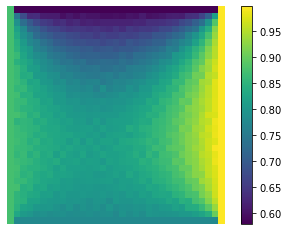

Solution from dataset:


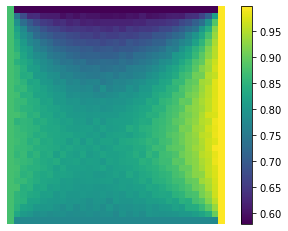

Error (dataset v.s. jacobi):


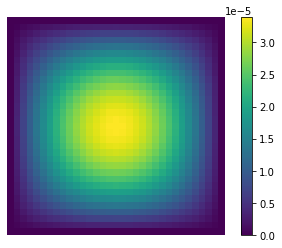

In [8]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-grid.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [13]:
class HNet(nn.Module):
    def __init__(self, nb_layers):
        super(HNet, self).__init__()

        self.convLayers = nn.ModuleList([nn.Conv2d(1, 1, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, geo_idx):
        '''geo_idx: internal points 1; boundary points 0'''
        return reduce(lambda acc, el: el(acc) * geo_idx, self.convLayers, x)

In [6]:
class HJacIterator(nn.Module):
    def __init__(self, 
                 size=2, 
                 n=2**5,
                 batch_size=64,
                 max_epochs=1000,
                 nb_layers=3):
        super(HJacIterator, self).__init__()
        self.size = size
        self.n = n
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.grid = SingleGrid(size, n)
        self.net = HNet(nb_layers)
        self.optimizer = torch.optim.Adadelta(self.net.parameters())

        self.model_dir='Model/learn_iterator/iso_poisson'
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

    def HRelax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of modified Jacobi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, f)
            u = jac_it + self.net(jac_it-u, self.grid.jac.geometry_idx)
        return u

    def random_sampling(x):
        u = torch.randn_like(x)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            u_train, f_train, bc_value_train, bc_index_train = data
        
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = random.randint(1,8)

            self.grid.ResetBoundary(bc_index_train, bc_value_train)
            ff = self.grid.fnet(f_train)
            uu = self.grid.jac.reset_boundary(self.random_sampling(f_train))
            
            u_out = self.HRelax(uu, ff, k)
            loss_i = self.mse_loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        for epoch in range(self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            print(epoch, avg_loss)
    
            # Track best performance, and save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train


tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])

Average q:  tensor(0.1983) , STD:  tensor(0.0131)


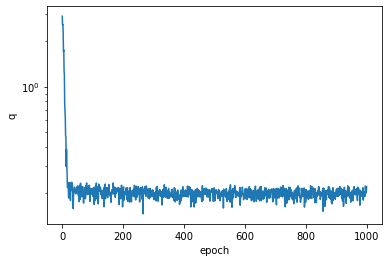

In [17]:
my_iterator = HJacobiIterator()
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

In [19]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


In [30]:
# import the learned model
#model_name = 'poisson_mg_kernel_17x17'
Ps = torch.load(os.path.join(model_dir,model_name+'-kernels.pt'))
#P = torch.mean(Ps[-100:,:,:],dim=0)
P = Ps[-1,:,:]
print('Learned Restriction/Prolongation kernel:')
print(P)

Learned Restriction/Prolongation kernel:
tensor([[0.3198, 0.5352, 0.3184],
        [0.5353, 0.8687, 0.5344],
        [0.3194, 0.5347, 0.3182]])


In [21]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

0 4.303105354309082
1 0.8379550576210022
2 0.18237589299678802
3 0.04077531024813652
4 0.009309359826147556
5 0.0021615447476506233
6 0.0005090598133392632
7 0.00012104624329367653
8 2.8986514735152014e-05
9 7.185014965216396e-06
Solution converges after 9 multi-grid iterations 


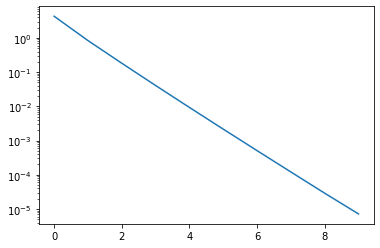

Multigrid solution:


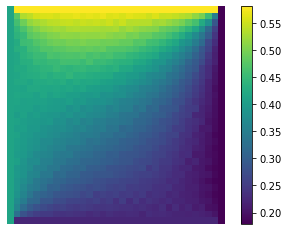

Solution from dataset:


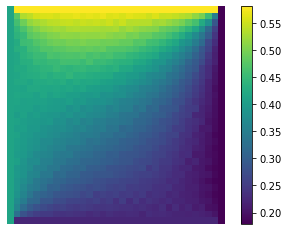

Error (dataset v.s. mg):


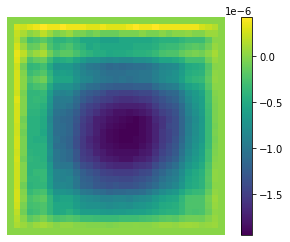

In [31]:
EPS = 1e-5
n = 2**5
model = MultiGrid(n, P) # create a new model
n_multigrid = 0
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
#u_mg = random_sampling(f_mg)
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = model.f-model.grids[0].Knet(model.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

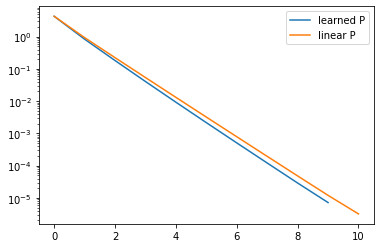

In [32]:
plt.plot(res_arr, label="learned P")
plt.plot(res_arr_linear, label="linear P")
plt.yscale('log')
plt.legend()
plt.show()

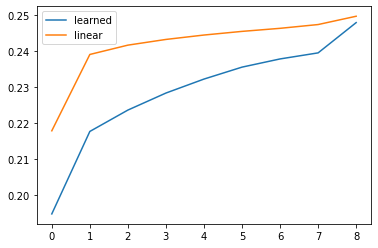

In [36]:
k = []
k_linear = []
for i in range(len(res_arr)-1):
    k.append(res_arr[i+1]/res_arr[i])
    k_linear.append(res_arr_linear[i+1]/res_arr_linear[i])

plt.plot(k, label = 'learned')
plt.plot(k_linear, label='linear')
plt.legend()

In [24]:
print("q is: ", compute_q(res_arr))
print("q hat is: " + str(float(model.loss(u_mg, len(res_arr)-1).detach())))

q is:  0.242199529176493
q hat is: 1.6256930166491657e-06


In [25]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.1887245923280716
6.571310011737677 0.2010144144296646
1.144095828095757 0.24095818400382996
3.762820113405668 0.2857430875301361
1.285842107227971 0.3394377827644348
2.8855768128300583 0.40330663323402405
1.4101545094683223 0.4792734980583191
2.47634326142357 0.5695580244064331
1.5136780448918956 0.676983654499054
2.2493800225123253 0.8048299551010132
1.5968602055764027 0.9567620754241943
2.1129421822315706 1.1371899843215942
1.6613445405017153 1.351672649383545
2.025374426743576 1.6068735122680664
1.7101370247488619 1.910357117652893
1.9679901033287657 2.270916700363159
1.7466234255282 2.699281692504883
1.9290668723158666 3.2087647914886475
1.7731105053071017 3.8148350715637207
1.9025917223887077 4.5350661277771
1.792657707102398 5.390636920928955
1.8842065802210468 6.407895565032959
1.8064153145950703 7.61809778213501
1.8714270671349325 9.056654930114746
1.816615349465342 10.765520095825195
1.8624827348472983 12.797175407409668
1.8235604961317993 15.214228630065918
1.8562154406

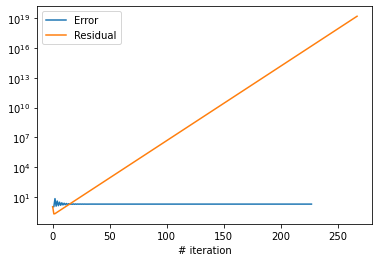

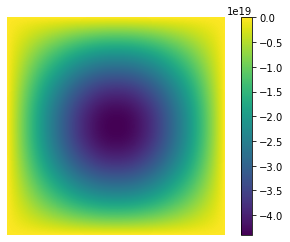

In [26]:
# Multigrid implementation
n = 2**9
model_mg = MultiGrid(n, P) # create a new model
prob_mg = mgTest(model_mg, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [27]:
print("q is: ", compute_q(res_arr_Vcycle))

q is:  inf
